In [1]:
# Import libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense
import tensorflow_datasets as tfds

In [2]:
# Extract data
data = pd.read_csv('../../ETL/Load/stockData.csv', header=(0), sep=';')

In [3]:
# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)
# Replace 0 class to -1 (for the tanh activation function)
data['CLASS'] = data['CLASS'].replace(0, -1)

In [4]:
data

,TICKER,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,CLASS
0,ABEV3,2014-07-01,21.706832,2.906275,0.258062,0.634963,0.029252,5.601715,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
1,ABEV3,2014-08-01,22.676506,2.906275,0.258062,0.634963,0.028001,5.851952,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
2,ABEV3,2014-09-01,22.219375,2.906275,0.258062,0.634963,0.028577,5.733983,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
3,ABEV3,2014-10-01,22.718062,2.906275,0.258062,0.634963,0.027950,5.862676,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
4,ABEV3,2014-11-01,23.216752,2.906275,0.258062,0.634963,0.027349,5.991369,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,YDUQ3,2023-08-01,-102.017902,10.561267,-0.018731,-0.677386,0.006640,1.910868,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1
11359,YDUQ3,2023-09-01,-99.513781,10.561267,-0.018731,-0.677386,0.006807,1.863964,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1
11360,YDUQ3,2023-10-01,-88.796136,10.561267,-0.018731,-0.677386,0.007629,1.663214,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1
11361,YDUQ3,2023-11-01,-100.615591,10.561267,-0.018731,-0.677386,0.006732,1.884601,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1


In [5]:
# Separate train and test data
# Train: first 8 years
# Test: last 2 years

data['DATE'] = pd.to_datetime(data['DATE'])
data_train = data[data['DATE'].dt.year <= 2021]
data_test = data[data['DATE'].dt.year > 2021]

In [6]:
data_train = data[data['DATE'].dt.year <= 2021]
data_test = data[data['DATE'].dt.year > 2021]

In [7]:
# Change data to numpy
data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

# Get number of rows and columns
ncol = data.shape[1]

# Get arrays for features and class
y_train = data_train[:,-1]
X_train = data_train[:,2:ncol-1]
y_test = data_test[:,-1]
X_test = data_test[:,2:ncol-1]

In [8]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [9]:
# Convert y to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [10]:
# Upsample 1 Class
# Convert X_train and y_train to DataFrame and Series, respectively
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Split the dataset by class
X_train_majority = X_train[y_train == -1]
X_train_minority = X_train[y_train == 1]

y_train_majority = y_train[y_train == -1]
y_train_minority = y_train[y_train == 1]

# Resample minority class to match the majority class size
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     
                                      n_samples=len(X_train_majority),  
                                      random_state=42)

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,     
                                      n_samples=len(y_train_majority),  
                                      random_state=42)

# Combine majority class and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [11]:
## Define adaptative learning rate
#def scheduler(epoch, lr):
#  if epoch < 2:
#    return lr
#  else:
#    return np.round(lr * tf.math.exp(-0.1), 6)

#callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [12]:
# Implement MLP
epochs = 500

# Number of input features
input_neurons = 11

# Create the MLP model
MLP = Sequential()

# Define the input layer
MLP.add(Input(shape=(input_neurons,)))

# Hidden layer with 22 neurons (2x input neurons) and tangent sigmoid activation
MLP.add(Dense(22, activation='tanh'))

# Output layer with tangent sigmoid activation
MLP.add(Dense(1, activation='tanh'))

# RMSprop with learning rate, decay, and momentum
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Compile the model
MLP.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
MLP.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 22)                  │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287 (1.12 KB)

 Trainable params: 287 (1.12 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
histMLP = MLP.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=epochs,
    verbose=2
)

Epoch 1/500
493/493 - 1s - 1ms/step - loss: 0.9819
Epoch 2/500
493/493 - 0s - 566us/step - loss: 0.9672
Epoch 3/500
493/493 - 0s - 561us/step - loss: 0.9599
Epoch 4/500
493/493 - 0s - 591us/step - loss: 0.9558
Epoch 5/500
493/493 - 0s - 571us/step - loss: 0.9512
Epoch 6/500
493/493 - 0s - 583us/step - loss: 0.9468
Epoch 7/500
493/493 - 0s - 570us/step - loss: 0.9441
Epoch 8/500
493/493 - 0s - 552us/step - loss: 0.9422
Epoch 9/500
493/493 - 0s - 566us/step - loss: 0.9394
Epoch 10/500
493/493 - 0s - 557us/step - loss: 0.9401
Epoch 11/500
493/493 - 0s - 559us/step - loss: 0.9367
Epoch 12/500
493/493 - 0s - 591us/step - loss: 0.9356
Epoch 13/500
493/493 - 0s - 583us/step - loss: 0.9341
Epoch 14/500
493/493 - 0s - 586us/step - loss: 0.9339
Epoch 15/500
493/493 - 0s - 552us/step - loss: 0.9333
Epoch 16/500
493/493 - 0s - 576us/step - loss: 0.9321
Epoch 17/500
493/493 - 0s - 547us/step - loss: 0.9313
Epoch 18/500
493/493 - 0s - 579us/step - loss: 0.9289
Epoch 19/500
493/493 - 0s - 599us/step 

Text(0.5, 1.0, 'Loss per epoch')

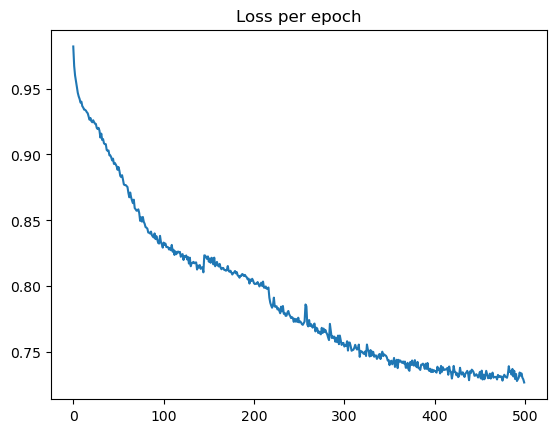

In [14]:
plt.plot(histMLP.history['loss'])
plt.title("Loss per epoch")

In [15]:
# Scale the test data
X_test = scaler.transform(X_test)

In [16]:
# Run model prediction
y_pred = MLP.predict(X_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


In [17]:
# Get cutoff point
# Generate cutoff points
cutoff_points = np.linspace(-1, 1, 100)

# Initialize lists to store rates
true_positive_rates = []
true_negative_rates = []

# Calculate rates for each cutoff
for cutoff in cutoff_points:
    # Classify predictions based on the cutoff
    y_pred_classes = np.where(y_pred.flatten() >= cutoff, 1, -1)
    
    # Compute true positives and true negatives
    true_positives = np.sum((y_pred_classes == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred_classes == -1) & (y_test == -1))
    
    # Total positives and negatives in the true labels
    total_positives = np.sum(y_test == 1)
    total_negatives = np.sum(y_test == -1)
    
    # True positive rate (TPR) and true negative rate (TNR)
    tpr = true_positives / total_positives if total_positives > 0 else 0
    tnr = true_negatives / total_negatives if total_negatives > 0 else 0
    
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Find the cutoff where the two curves cross
# This happens when |TPR - TNR| is minimized
tpr_array = np.array(true_positive_rates)
tnr_array = np.array(true_negative_rates)
cutoff_cross = cutoff_points[np.argmin(np.abs(tpr_array - tnr_array))]

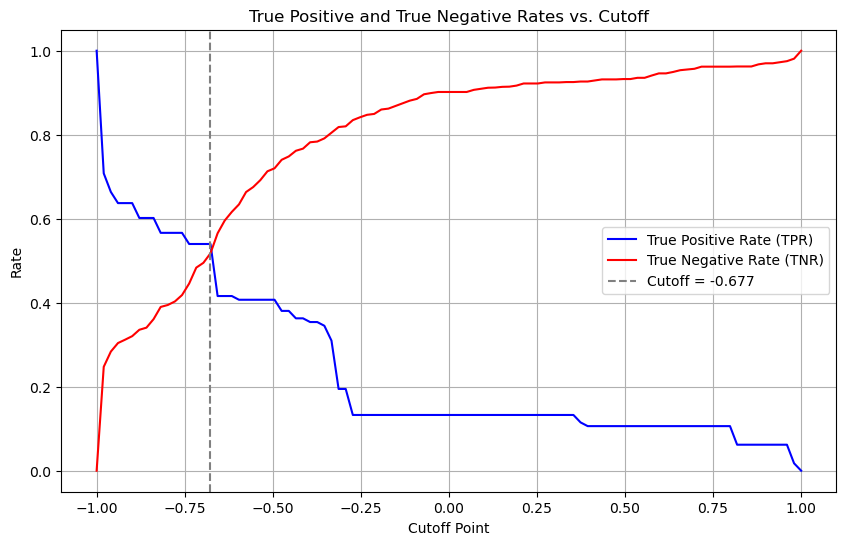

In [18]:
# Plot the TPR and TNR
plt.figure(figsize=(10, 6))
plt.plot(cutoff_points, true_positive_rates, label='True Positive Rate (TPR)', color='blue')
plt.plot(cutoff_points, true_negative_rates, label='True Negative Rate (TNR)', color='red')
plt.axvline(cutoff_cross, color='gray', linestyle='--', label=f'Cutoff = {round(cutoff_cross,3)}')
plt.xlabel('Cutoff Point')
plt.ylabel('Rate')
plt.title('True Positive and True Negative Rates vs. Cutoff')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Treat predicted array
y_pred[y_pred>=cutoff_cross] = 1
y_pred[y_pred<cutoff_cross] = 0
y_pred = np.sign(y_pred.flatten())
y_pred.astype(int)

# Treat test array
y_test[y_test==-1] = 0

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

Accuracy: 0.5187122736418511
Precision: 0.05062240663900415
Recall (Sensitivity): 0.5398230088495575
F1-Score: 0.09256449165402124


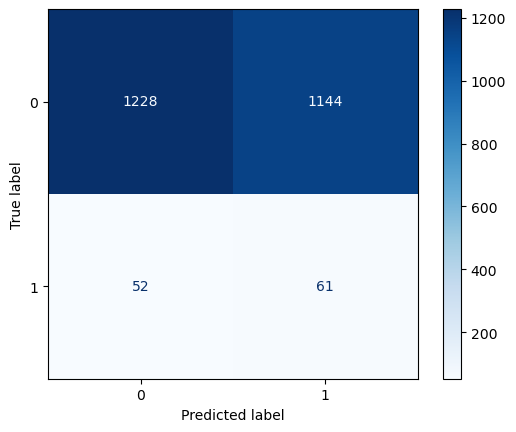

In [21]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()